In [1]:
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import glob
from netCDF4 import Dataset
import copy
import gc
import ant_plus

import os
import sys
sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

In [5]:
f_nc = Dataset('DATA/cs_plus_antarctica_sea_level_v0.2.nc')
lats = f_nc['lat'][:]
lons = f_nc['lon'][:]
DOT = f_nc['dot'][:]

f_nc.close()

In [7]:
m = ccrs.SouthPolarStereo()
G1 = gs.grid_set(m)
G2 = gs.grid_set(m)

In [8]:
G1.set_grid_lon_lat(lons,lats,fill_lonlat=True)

Got a grid res =  720  x  120
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


In [9]:
G2.load_grid('Polar_stereo_50km_SH.npz')

Loaded a grid: Polar_stereo_50km_SH.npz


In [20]:
G1.get_grid_mask()
G2.get_grid_mask()

In [10]:
G12G2 = gs.Gs2Gs(G1,G2)

In [47]:
### plotting grid
f = plt.figure()
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent(G2.x_extent, m)
Gplot = gs.grid_set(m)
Gplot.set_grid_mn(30,30,ax)
Gplot.gridinfo = False
Gplot.get_grid_info(av_ang=False)

G2Gplot= gs.Gs2Gs(G2,Gplot,vectors=True)
f.clear()

Got a grid res =  30  x  30
Grid distances calculated:  326725.68265444157  x  326725.68265444145
Angles calculated


<Figure size 432x288 with 0 Axes>

In [17]:
DOT_PS = np.empty((12,)+G2.shape)
for nt in range(12):
    DOT_PS[nt] = G12G2.rg_array(DOT[nt])

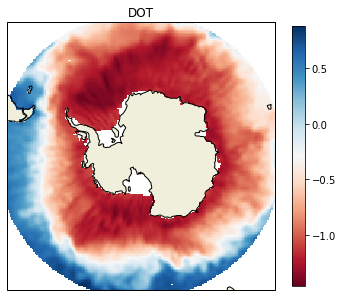

In [48]:
nt = 3
f = plt.figure(figsize=[6,6])
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
s = ax.pcolormesh(G2.xptp,G2.yptp,DOT_PS[nt],
                 cmap = 'RdBu')
ax.set_title('DOT')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s,shrink=0.8,pad=0.05)
plt.show()

In [81]:
radius = 100e3 ### 100 km
limits = [-2.0,2.0]
trim = [1,99]
DOT_filt = np.empty((12,)+G2.shape)
for i in range(12):
    L1,L2 = np.nanpercentile(DOT_PS[i,:,:],trim)
    lim0 = np.maximum(limits[0],L1)
    lim1 = np.minimum(limits[1],L2)
    print("Smoothing:"
          +'{:.3}'.format(lim0)+'  '
          +'{:.3}'.format(lim1))
    temp_mask = G2.mask.copy()
    temp_mask[np.isnan(DOT_PS[i,:,:])] = np.nan
    # the DOT has to be premasked to remove land points
    # and limits -  this happens within
    DOT_filt[i]=gs.geo_convolve(
            DOT_PS[i,:,:],G2,radius,[lim0,lim1],mask=temp_mask)

Smoothing:-1.35  0.684
Smoothing:-1.35  0.668
Smoothing:-1.38  0.684
Smoothing:-1.38  0.719
Smoothing:-1.39  0.657
Smoothing:-1.44  0.671
Smoothing:-1.43  0.678
Smoothing:-1.43  0.699
Smoothing:-1.46  0.739
Smoothing:-1.43  0.716
Smoothing:-1.38  0.671
Smoothing:-1.38  0.669


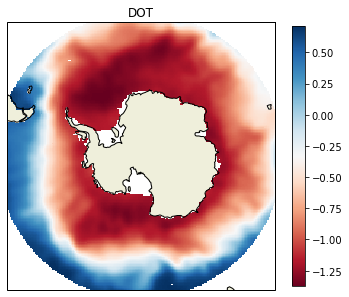

In [82]:
nt = 3
f = plt.figure(figsize=[6,6])
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
s = ax.pcolormesh(G2.xptp,G2.yptp,DOT_filt[nt],
                 cmap = 'RdBu')
ax.set_title('DOT')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s,shrink=0.8,pad=0.05)
plt.show()

In [83]:
geo_x = np.empty((12,)+G2.shape)
geo_y = np.empty((12,)+G2.shape)
omega=2.*np.pi/24./60./60.
g = 9.8
fcor = 2.*omega*np.sin(np.deg2rad(G2.lats))
for tt in range(12):
    g1,g2= gs.geo_gradient(DOT_filt[tt],G2)
    geo_x[tt] = -g1*g/fcor
    geo_y[tt] =  g2*g/fcor
    print(tt,['{:.3}'.format(pc) for pc in np.nanpercentile(np.hypot(geo_x[tt],geo_y[tt]),[25,50,75])])

0 ['0.0229', '0.0484', '0.0839']
1 ['0.0223', '0.0484', '0.0841']
2 ['0.0247', '0.0496', '0.087']
3 ['0.0257', '0.0516', '0.088']
4 ['0.0254', '0.0515', '0.0878']
5 ['0.0266', '0.0529', '0.0861']
6 ['0.0254', '0.0525', '0.0859']
7 ['0.024', '0.0542', '0.0874']
8 ['0.0267', '0.0558', '0.0899']
9 ['0.0245', '0.055', '0.0878']
10 ['0.0239', '0.0508', '0.083']
11 ['0.0228', '0.0484', '0.0827']


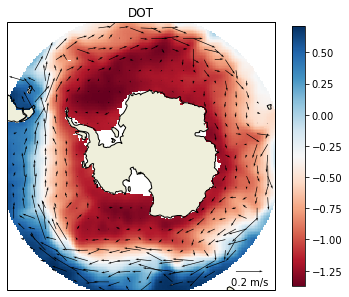

In [84]:
nt = 3
i,j = 24,4
ur,vr = G2Gplot.rg_vecs(geo_x[nt],geo_y[nt])
ur[i,j] = 0.2
vr[i,j] = 0.0
f = plt.figure(figsize=[6,6])
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
s = ax.pcolormesh(G2.xptp,G2.yptp,DOT_filt[nt],
                 cmap = 'RdBu')
ax.quiver(Gplot.xptp,Gplot.yptp,ur,vr,
         scale_units = 'width',scale=1/0.5)
ax.set_title('DOT')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.text(Gplot.xpts[i-1,j-1],Gplot.ypts[i,j-1],'0.2 m/s',
                     verticalalignment='top',fontsize=10)
plt.colorbar(s,shrink=0.8,pad=0.05)
plt.show()